In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load data using full path
df = pd.read_csv(r"C:\Users\Kunal\OneDrive\Desktop\credit_card_anomaly_detection\creditcard.csv")

# Scale 'Amount' and 'Time'
df['scaled_amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Amount', 'Time'], axis=1, inplace=True)

# Reorder columns
scaled_features = ['scaled_amount', 'scaled_time']
df = df[scaled_features + [col for col in df.columns if col not in scaled_features]]

df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [9]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Separate features and labels
X = df.drop('Class', axis=1)
y = df['Class']

# Fit Isolation Forest (unsupervised)
iso = IsolationForest(contamination=0.001, random_state=42)
iso.fit(X)

# Predict: -1 means anomaly, 1 means normal
iso_preds = iso.predict(X)
iso_preds = [1 if p == -1 else 0 for p in iso_preds]  # Convert -1 to 1 (fraud), 1 to 0 (normal)

# Evaluate
print("Isolation Forest F1 Score:", f1_score(y, iso_preds))
print("\nClassification Report:\n", classification_report(y, iso_preds))
print("\nConfusion Matrix:\n", confusion_matrix(y, iso_preds))


Isolation Forest F1 Score: 0.2676962676962677

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.36      0.21      0.27       492

    accuracy                           1.00    284807
   macro avg       0.68      0.61      0.63    284807
weighted avg       1.00      1.00      1.00    284807


Confusion Matrix:
 [[284134    181]
 [   388    104]]


In [10]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Use only normal (non-fraud) transactions for training
X_normal = X[y == 0]

# Define autoencoder architecture
input_dim = X.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder on normal data
autoencoder.fit(X_normal, X_normal, epochs=20, batch_size=256, shuffle=True, validation_split=0.1, verbose=1)


Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.8609 - val_loss: 0.4093
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3769 - val_loss: 0.3453
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3270 - val_loss: 0.3303
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3120 - val_loss: 0.3134
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2999 - val_loss: 0.3039
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2920 - val_loss: 0.2953
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2891 - val_loss: 0.2910
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2842 - val_loss: 0.2860
Epoch 9/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2769 - val_loss: 0.2834
Epoch 10/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2770 - val_loss: 0.2778
Epoch 11/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2737 - val_loss: 0.2736
Epoch 12/20
1000/1000 ━━━━━━━━

In [11]:
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Get reconstruction for all data points
reconstructions = autoencoder.predict(X)

# Calculate MSE (mean squared error) between original and reconstructed features
mse = np.mean(np.power(X - reconstructions, 2), axis=1)

# Set threshold for anomaly detection (e.g., 99th percentile of errors on normal data)
threshold = np.percentile(mse[y == 0], 99)

# Predict fraud if error > threshold
auto_preds = (mse > threshold).astype(int)

# Evaluate
print("Autoencoder F1 Score:", f1_score(y, auto_preds))
print("\nClassification Report:\n", classification_report(y, auto_preds))
print("\nConfusion Matrix:\n", confusion_matrix(y, auto_preds))


8901/8901 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Autoencoder F1 Score: 0.21413276231263384

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    284315
           1       0.12      0.81      0.21       492

    accuracy                           0.99    284807
   macro avg       0.56      0.90      0.60    284807
weighted avg       1.00      0.99      0.99    284807


Confusion Matrix:
 [[281471   2844]
 [    92    400]]


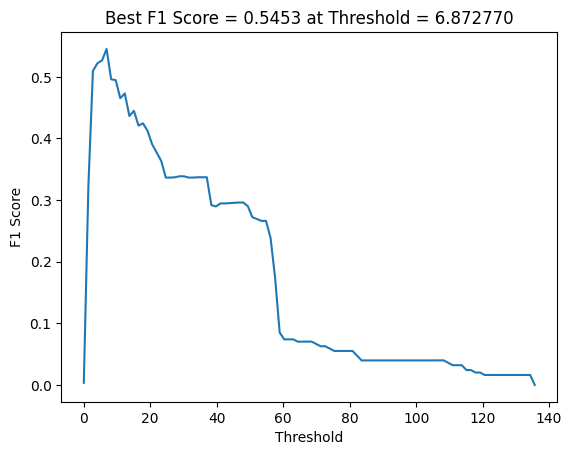

Best threshold: 6.872770280483938
Best F1 score: 0.5452631578947369


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

thresholds = np.linspace(min(mse), max(mse), 100)
f1_scores = []

for t in thresholds:
    preds = (mse > t).astype(int)
    f1_scores.append(f1_score(y, preds))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title(f'Best F1 Score = {f1_scores[best_idx]:.4f} at Threshold = {best_threshold:.6f}')
plt.show()

print(f"Best threshold: {best_threshold}")
print(f"Best F1 score: {f1_scores[best_idx]}")


In [13]:
auto_preds = (mse > best_threshold).astype(int)


In [14]:
pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
from imblearn.over_sampling import SMOTE

# Split features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Apply SMOTE only on training data — since we don't have separate train/test here, do it directly
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Before SMOTE: {X.shape}, After SMOTE: {X_resampled.shape}")
print(f"Class distribution after SMOTE:\n{pd.Series(y_resampled).value_counts()}")

# Train autoencoder only on normal transactions after resampling
X_normal_resampled = X_resampled[y_resampled == 0]

# Define autoencoder architecture (same as before)
input_dim = X_normal_resampled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder on normal data from resampled dataset
autoencoder.fit(X_normal_resampled, X_normal_resampled, epochs=20, batch_size=256, shuffle=True, validation_split=0.1, verbose=1)


Before SMOTE: (284807, 30), After SMOTE: (568630, 30)
Class distribution after SMOTE:
Class
0    284315
1    284315
Name: count, dtype: int64
Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7817 - val_loss: 0.4113
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3790 - val_loss: 0.3678
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3428 - val_loss: 0.3415
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3222 - val_loss: 0.3302
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3125 - val_loss: 0.3216
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3006 - val_loss: 0.3123
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2959 - val_loss: 0.3045
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2928 - val_loss: 0.3016
Epoch 9/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2860 - val_loss: 0.2909
Epoch 10/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2

In [16]:
# Predict reconstruction error on original X
reconstructions = autoencoder.predict(X)

mse = np.mean(np.power(X - reconstructions, 2), axis=1)

# Find best threshold (you can reuse the threshold tuning code I shared before)


8901/8901 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


In [17]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

print("Autoencoder F1 Score:", f1_score(y, auto_preds))
print("\nClassification Report:\n", classification_report(y, auto_preds))
print("\nConfusion Matrix:\n", confusion_matrix(y, auto_preds))


Autoencoder F1 Score: 0.5452631578947369

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.57      0.53      0.55       492

    accuracy                           1.00    284807
   macro avg       0.78      0.76      0.77    284807
weighted avg       1.00      1.00      1.00    284807


Confusion Matrix:
 [[284116    199]
 [   233    259]]
